In [1]:
import numpy as np
import matplotlib.pyplot as pl
import time
from joblib import Parallel, delayed
import pyfftw

In [2]:
c = 3e8
G = 6.67e-11
pi = np.pi
const = 96/5*pi**(8/3)*(G/c**3)**(5/3)

In [34]:
f0 = 150
Mc = 1e-3* 2e30
f_max = 200
T_obs = 1e4
pad_len0 = int(340.0*T_obs) #~0.01 added length to resampled data
beta = const*f0**(8/3)*Mc**(5/3)

f_signal = 40*f_max
nt = round(f_signal*T_obs)
t = np.arange(nt)/f_signal
f_ratio = 25

In [35]:
beta

3.7005336330685566e-06

In [36]:
phi = -6*pi/5*f0*(1-8./3.*beta*t)**(5/8)/beta
phi = np.mod(phi,2*pi)
signal = 1*np.exp(1j*phi)

nh = 0
noise = nh*np.random.normal(size = nt)
data = signal + noise

In [37]:
def strobo(beta, data, f_ratio):
    new_t = -3/5*(1-8/3*beta*t)**(5/8)/beta
    f_new = f_signal/f_ratio
    
    new_t *= f_new #changes the frequency to the new downsampled frequency (approximately, not exactly)
    floor_t = np.floor(new_t) #For some reason floor works better than round. Take it to the nearest time index which are integers
    idx = np.nonzero(np.diff(floor_t)) #The step that downsamples
    resampled = data[idx]
    t_out = (new_t[idx]-new_t[0])/f_new
    return (resampled, t_out)

In [38]:
f_ratio = 25
out, t_out = strobo(beta, data, f_ratio)
padded = np.zeros(pad_len0, dtype = np.complex128)
padded[:len(out)] = out
corrected = np.fft.fftshift(np.fft.fft(padded))
freq_corrected = np.fft.fftshift(np.fft.fftfreq(pad_len0, d=t_out[1]-t_out[0]))
corrected = corrected[len(corrected)//2:]
resampled_power = np.abs(corrected/len(out))**2

freq_corrected = freq_corrected[len(freq_corrected)//2:]
nt_new = len(out)

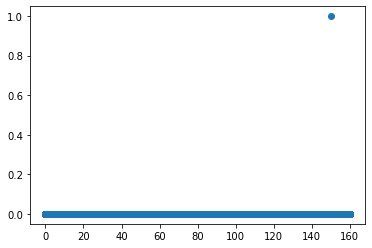

In [39]:
pl.plot(freq_corrected, resampled_power, 'o')
# pl.xlim(119.995, 120.005)

In [40]:
max(resampled_power)

0.9987977913733269

In [28]:
def power_calc(beta, f0):
    phi = -6*pi/5*f0*(1-8./3.*beta*t)**(5/8)/beta
    phi = np.mod(phi,2*pi)
    signal = 1*np.exp(1j*phi)
    data = signal
    
    out, t_out = strobo(beta, data, f_ratio)
    padded = np.zeros(pad_len0, dtype = np.complex128)
    padded[:len(out)] = out
    corrected = np.fft.fftshift(np.fft.fft(padded))
    freq_corrected = np.fft.fftshift(np.fft.fftfreq(pad_len0, d=t_out[1]-t_out[0]))
    corrected = corrected[len(corrected)//2:]
    resampled_power = np.abs(corrected/len(out))**2
    return max(resampled_power)

In [29]:
beta_arr = np.logspace(-11, -7, 5)
ref_power = [power_calc(i, 20) for i in beta_arr]

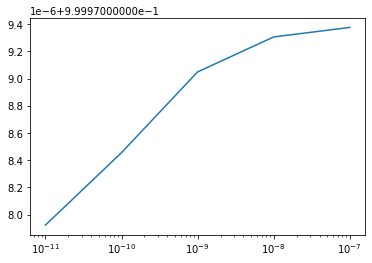

In [30]:
pl.semilogx(beta_arr, ref_power)

In [32]:
beta_arr = np.logspace(-8, -5, 10)
ref_power = [power_calc(i, 150) for i in beta_arr]

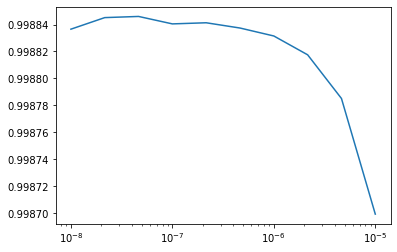

In [33]:
pl.semilogx(beta_arr, ref_power)

In [ ]:
# Conclusion: reference power is almost independent of all parameters
# as expected. 